<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modelling lab: Can we predict risk of bankruptcy?

In this exercise we will try to predict companies that go bankrupt in the next 5 years, based on various numeric financial attributes. The dataset describes Polish companies and their financial accounts, and further information is [available here](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data). For this exercise we chose only the companies that went bankrupt within 5 years (one of the five available datasets on the site).

# Part 1 - Exploratory data analysis

### 1. Load the data

Look at the usual things:

- how many rows/columns?
- what are the data types?
- any missing values?

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv("../data/bankruptcy.csv")
print(df.shape)
df.head(2).T

(7027, 65)


,0,1
net profit / total assets,0.200550,0.209120
total liabilities / total assets,0.379510,0.499880
working capital / total assets,0.396410,0.472250
current assets / short-term liabilities,2.047200,1.944700
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,32.351000,14.786000
retained earnings / total assets,0.388250,0.000000
EBIT / total assets,0.249760,0.258340
book value of equity / total liabilities,1.330500,0.996010
sales / total assets,1.138900,1.699600
equity / total assets,0.504940,0.497880


So they're all numeric except the binary target, which is an integer

In [5]:
# check out the target variable
df['bankruptcy_label'].value_counts()

0    6756
1     271
Name: bankruptcy_label, dtype: int64

<AxesSubplot:>

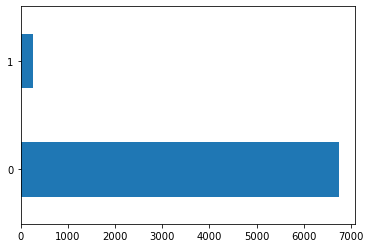

In [6]:
# imbalanced classes!
df['bankruptcy_label'].value_counts().plot(kind='barh')

In [7]:
df.isnull().sum().values

array([   3,    3,    3,   30,    8,    3,    3,   25,    1,    3,   39,
         30,    0,    3,    2,   25,   25,    3,    0,    0, 1622,    3,
          0,  124,    3,   25,  311,   34,    3,    0,    0,   38,   30,
         25,    3,    3, 2740,    3,    0,   30,   84,    0,    0,    0,
        134,   31,   29,    3,    0,   25,    3,   29,   34,   34,    0,
          0,    1,    0,    1,  135,   22,    0,   30,   34,    0],
      dtype=int64)

Some columns are missing more values than others, let's look at the worst offenders

In [8]:
print(len(df))
df.isnull().sum().sort_values(ascending=False).head()

7027


(current assets - inventories) / long-term liabilities    2740
sales (n) / sales (n-1)                                   1622
profit on operating activities / financial expenses        311
sales / inventory                                          135
net profit / inventory                                     134
dtype: int64

We'll deal with missing values later, depending on which features we use for prediction

### 2. Examine the target

The target is the final column, `bankruptcy_label` (1 if the company went bankrupt within 5 years).

What is the distribution of the target?

In [17]:
df["bankruptcy_label"].value_counts(normalize=True)

0    0.961434
1    0.038566
Name: bankruptcy_label, dtype: float64

So it's an imbalanced dataset, only <4% of the companies went bankrupt within 5 years

### 3. Create a heatmap showing the correlations within your features

It's generally a good idea to see how your features correlate to each other, to identify columns that perhaps encode the same information. We'll do this by calculating the correlation matrix (how every column correlates with every other) and inspect it visually as a heatmap.

#### 3. a. Get a correlation matrix of your features (hint: there's a built in `pandas` function for that!

In [18]:
corr_matrix = df.drop("bankruptcy_label", axis=1).corr()
corr_matrix.head(2)

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold),equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets
net profit / total assets,1.000000,-0.155932,0.159913,0.014650,0.008364,0.129868,0.422068,0.016007,-0.561939,-0.349011,0.397936,0.053170,0.000667,0.422068,0.000146,0.047888,0.015390,0.422068,0.003726,-0.000068,-0.004889,0.463856,0.003743,0.266205,-0.646808,0.033544,0.008489,0.004493,0.087485,-0.000417,0.003745,-0.138953,0.042241,0.039684,-0.059102,-0.561856,-0.000551,-0.349053,0.000634,0.005682,-0.005399,0.000724,-0.000066,-0.000066,0.001046,0.011966,0.000051,0.490985,0.000253,0.036325,-0.158139,-0.100931,-0.008174,-0.008157,0.002983,0.000061,0.004398,-0.000061,0.000287,-0.000375,0.009186,-0.000848,0.049427,-0.041161
total liabilities / total assets,-0.155932,1.000000,-0.985782,-0.010019,-0.052235,-0.772227,-0.193355,-0.008612,-0.073338,-0.221383,-0.103102,-0.010755,-0.002873,-0.193355,0.000332,-0.007249,-0.010606,-0.193355,-0.017806,0.000656,-0.003277,-0.106255,-0.018350,-0.176283,-0.195784,-0.007001,-0.005003,-0.017878,-0.050353,0.002882,-0.017816,0.856251,-0.017536,-0.003286,-0.114210,-0.073245,-0.032585,-0.221321,0.001318,-0.004600,0.039239,0.001164,0.000668,0.000673,-0.002783,-0.007730,-0.000523,-0.100451,-0.000514,-0.020642,0.986503,0.628823,-0.066144,-0.065868,-0.009709,-0.000655,-0.000743,0.000656,0.000979,-0.000016,-0.002368,0.005456,-0.017961,-0.104069


#### 3. b. Use `seaborn` to plot a heatmap of your correlation matrix

You will need to play around with the plotting options to get a clear view of where the correlations are

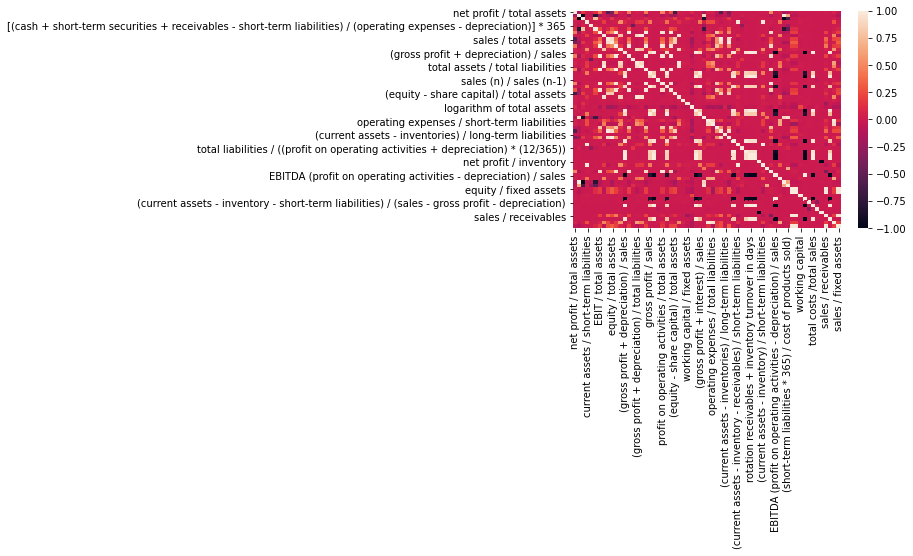

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.heatmap(corr_matrix);

Because there are a lot of columns, and their names are long, the default heatmap doesn't look great. Let's play around with the options

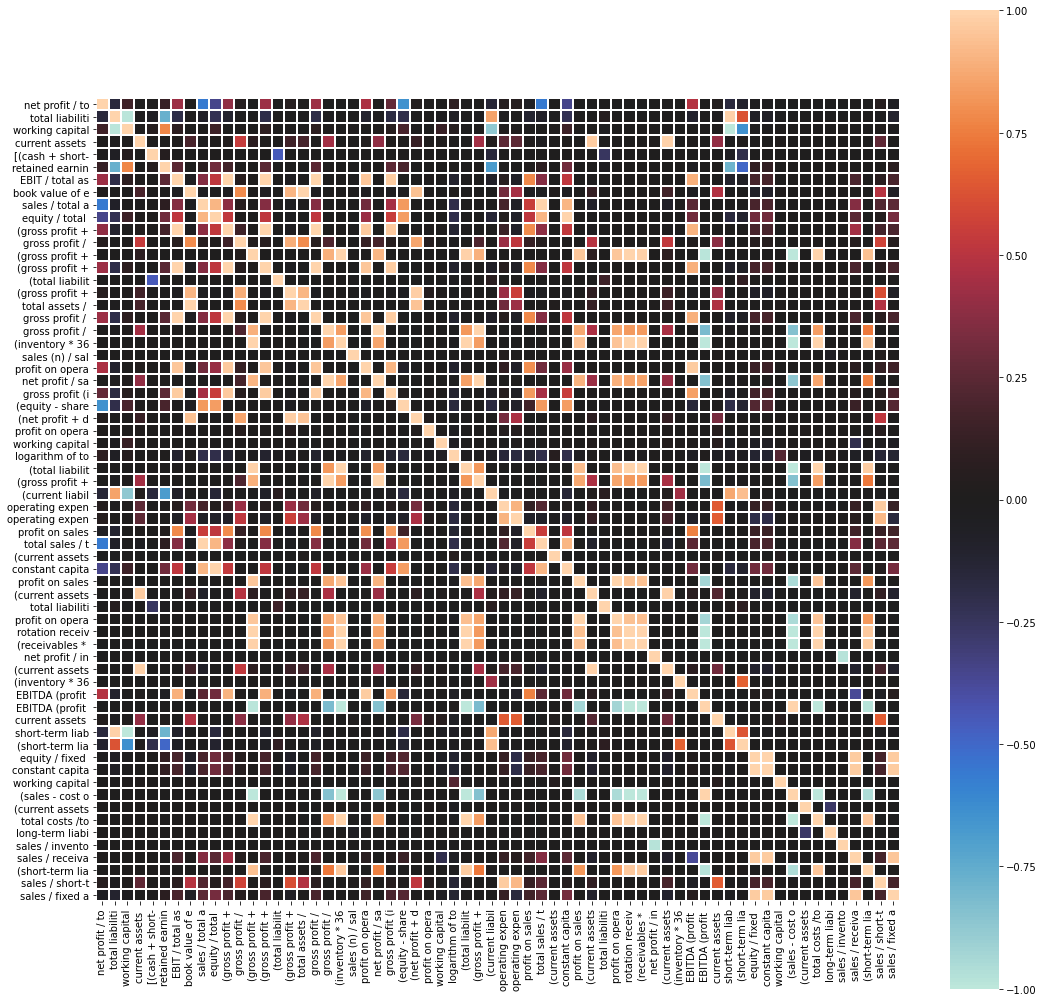

In [20]:
fig, ax = plt.subplots(figsize=(18, 18))

corr_matrix_to_plot = corr_matrix.copy()

# reduce column names to N chars max
max_chars = 15
corr_matrix_to_plot.columns = [c[:max_chars] for c in corr_matrix_to_plot.columns]
# same for index (i.e. row labels)
corr_matrix_to_plot.index = [c[:max_chars] for c in corr_matrix_to_plot.index]

sns.heatmap(
    data=corr_matrix_to_plot,
    vmin=-1,
    vmax=1, # explicitly set the boundaries
    center=0,
    square=True,
    linewidths=1,
    ax=ax
)

plt.show()

### 3. c. Dig into it a bit more, and find the top few strongest correlated column pairs

In [21]:
# A few ways to approach this, one is let's extract the column-pairs and their respective correlations,
# and find the top N unique highest ones

# Extract each possible column pair. Many ways to do this, but one clever one is to get a 'mask'
# where the correlations are close to 1 or -1, and use stack() to get the column-index list
# as per this SO answer: https://stackoverflow.com/a/26858881
correlation_pairs = corr_matrix[(corr_matrix > 0.9) | (corr_matrix < -0.9)].stack()

# this is a Series with a multi-index (basically pairs of column names)
correlation_pairs

net profit / total assets                                                                                            net profit / total assets                                                                                              1.000000
total liabilities / total assets                                                                                     total liabilities / total assets                                                                                       1.000000
                                                                                                                     working capital / total assets                                                                                        -0.985782
                                                                                                                     short-term liabilities / total assets                                                                                  0.986503
working capital / to

We can make it into a DataFrame and remove items where the two are the same (columns correlated with themselves) and remove duplicates

In [22]:
# make into a DataFrame
corr_df = correlation_pairs.reset_index(name="correlation")

# extract only those that aren't the self-correlations
corr_df = corr_df[corr_df["level_0"] != corr_df["level_1"]]

# sort by the absolute correlation value and find the top 10 pairs
corr_df["abs_correlation"] = abs(corr_df["correlation"])
corr_df.sort_values("abs_correlation", ascending=False).head(10)

,level_0,level_1,correlation,abs_correlation
50,(gross profit + interest) / total assets,EBIT / total assets,1.000000,1.000000
53,(gross profit + interest) / total assets,gross profit / total assets,1.000000,1.000000
65,gross profit / total assets,EBIT / total assets,1.000000,1.000000
14,EBIT / total assets,(gross profit + interest) / total assets,1.000000,1.000000
15,EBIT / total assets,gross profit / total assets,1.000000,1.000000
67,gross profit / total assets,(gross profit + interest) / total assets,1.000000,1.000000
246,total costs /total sales,(sales - cost of products sold) / sales,-1.000000,1.000000
235,(sales - cost of products sold) / sales,total costs /total sales,-1.000000,1.000000
82,(inventory * 365) / sales,(sales - cost of products sold) / sales,-0.999996,0.999996
227,(sales - cost of products sold) / sales,(inventory * 365) / sales,-0.999996,0.999996


Some of these are duplicates, so let's remove those. We can Google the problem and use a clever StackOverflow solution (https://stackoverflow.com/a/51303604)

In [23]:
import numpy as np

df1 = pd.DataFrame(np.sort(corr_df[['level_0','level_1']], axis=1))

# use negative indexing (~ operator) to only keep what ISN'T a duplicate pair
corr_df = corr_df.reset_index(drop=True)[~df1.duplicated()]

# show top 10
corr_df.sort_values("abs_correlation", ascending=False).head(10)

,level_0,level_1,correlation,abs_correlation
7,EBIT / total assets,(gross profit + interest) / total assets,1.000000,1.000000
39,(gross profit + interest) / total assets,gross profit / total assets,1.000000,1.000000
8,EBIT / total assets,gross profit / total assets,1.000000,1.000000
179,(sales - cost of products sold) / sales,total costs /total sales,-1.000000,1.000000
62,(inventory * 365) / sales,(sales - cost of products sold) / sales,-0.999996,0.999996
63,(inventory * 365) / sales,total costs /total sales,0.999996,0.999996
19,equity / total assets,constant capital / total assets,0.999990,0.999990
54,gross profit / sales,(gross profit + interest) / sales,0.999987,0.999987
132,rotation receivables + inventory turnover in days,(receivables * 365) / sales,0.999956,0.999956
165,equity / fixed assets,constant capital / fixed assets,0.999917,0.999917


So again, there are some strongly duplicated columns, which we want to bear in mind when choosing our features

### 4. Look at the distribution of your variables for bankrupt vs. non-bankrupt companies

We're looking for cases where the distribution of a feature is different for bankrupt companies, suggesting that it would be a good feature to separate the classes.

You could start by comparing the average value of each feature for bankrupt vs. non-bankrupt companies, or as a bonus plot the actual distribution (using histograms, box plots or similar).

In [24]:
# columns to look at are all but the last one
feature_cols = df.columns[:-1]

# group by the target and average each feature column
# and transpose using `.T` to see them side-by-side rather than above-below
# and rename to give columns meaningful names
feature_means = (
    df
        .groupby("bankruptcy_label")
        [feature_cols]
        .mean()
        .T
        .rename(columns={0:"non-bankrupt",
                         1:"bankrupt"})
)

feature_means.head()

bankruptcy_label,non-bankrupt,bankrupt
net profit / total assets,0.044393,-0.207890
total liabilities / total assets,0.490395,2.300058
working capital / total assets,0.188765,-1.594335
current assets / short-term liabilities,2.607667,3.162163
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,-248.210388,-635.598537


In [25]:
# calculate % diff between averages
# and sort by this column to see the ones that differ the most
# between bankrupt and non-bankrupt companies

feature_means["diff"] = (feature_means["bankrupt"] - feature_means["non-bankrupt"]) / feature_means["non-bankrupt"]
feature_means.sort_values("diff", ascending=False).head(10)

bankruptcy_label,non-bankrupt,bankrupt,diff
(current liabilities * 365) / cost of products sold,187.625382,1454.603303,6.752700
short-term liabilities / total assets,0.399219,2.173729,4.444952
total liabilities / total assets,0.490395,2.300058,3.690215
(short-term liabilities * 365) / cost of products sold),0.526354,2.030019,2.856757
(total liabilities * 365) / (gross profit + depreciation),1657.417894,5423.393672,2.272194
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,-248.210388,-635.598537,1.560725
(current assets - inventory - receivables) / short-term liabilities,0.800044,1.473633,0.841940
operating expenses / total liabilities,3.575546,5.919992,0.655689
current assets / total liabilities,2.017607,2.591571,0.284478
long-term liabilities / equity,0.275009,0.348118,0.265842


### 5. Based on findings from above, combined with your domain knowledge, choose 5 features with which to build a first predictive model

It is usually a good idea to choose uncorrelated features, and in the case of classification those that suggest a separation between labels 0 and 1 (i.e. features that are distinctly different for bankrupt and non-bankrupt companies).

Let's take the top 5 uncorrelated features from part 4. i.e. those that suggest a separation but are not strongly correlated

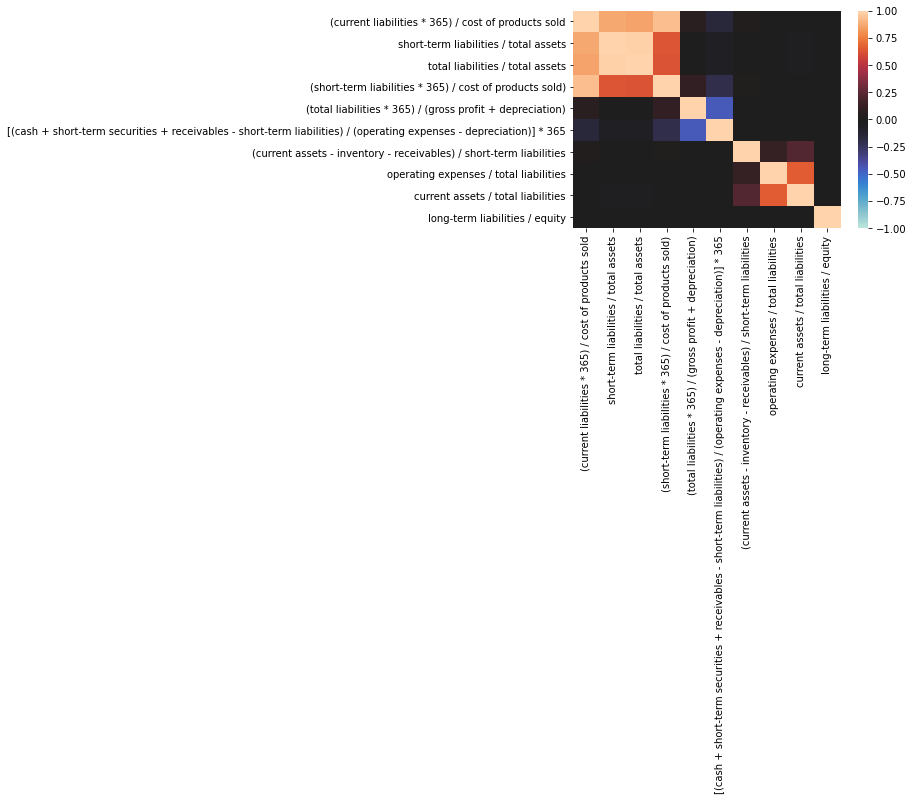

In [26]:
top_10_separation = feature_means.sort_values("diff", ascending=False).head(10)
top_10_colnames = top_10_separation.index

# get correlation matrix for the top 10 from above
corr_matrix_10 = df[top_10_colnames].corr()

sns.heatmap(corr_matrix_10,
            vmin=-1,
            vmax=1,
            center=0);

Eyeballing the above we'll use:

- 'total liabilities / total assets'
- '(total liabilities * 365) / (gross profit + depreciation)'
- (current assets - inventory - receivables) / short-term liabilities'
- 'operating expenses / total liabilities'
- 'long-term liabilities / equity'

Let's verify the correlation matrix

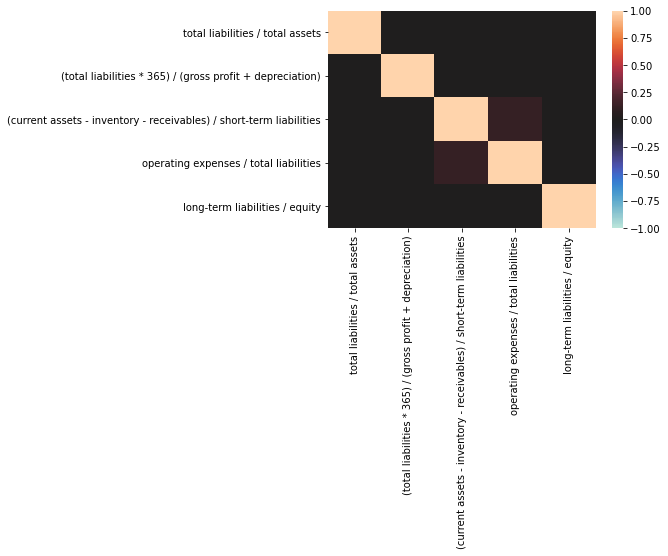

In [42]:
features_to_use = ['total liabilities / total assets',
                   '(total liabilities * 365) / (gross profit + depreciation)',
                   '(current assets - inventory - receivables) / short-term liabilities',
                   'operating expenses / total liabilities',
                   'long-term liabilities / equity']

sns.heatmap(df[features_to_use].corr(),
            vmin=-1,
            vmax=1,
            center=0);

In [46]:
# are they correlated with the outcome?
corr_list=features_to_use
corr_list.append('bankruptcy_label')
df[corr_list].corr()[['bankruptcy_label']].sort_values('bankruptcy_label', ascending=False)

,bankruptcy_label
bankruptcy_label,1.000000
total liabilities / total assets,0.065150
operating expenses / total liabilities,0.027680
(current assets - inventory - receivables) / short-term liabilities,0.010320
(total liabilities * 365) / (gross profit + depreciation),0.008643
long-term liabilities / equity,0.002221


In [36]:
features_to_use

['total liabilities / total assets',
 '(total liabilities * 365) / (gross profit + depreciation)',
 '(current assets - inventory - receivables) / short-term liabilities',
 'operating expenses / total liabilities',
 'long-term liabilities / equity',
 'bankruptcy_label',
 'bankruptcy_label',
 'bankruptcy_label']

In [34]:
# there's a lot of imbalance with bankruptcy
df["bankruptcy_label"].value_counts()

0    6756
1     271
Name: bankruptcy_label, dtype: int64

# Part 2 - Prediction

### 1. Using the features you selected above, create training and test sets

Ensure that both your training and test sets have the same distribution of bankrupt/non-bankrupt companies. You can use a specific parameter when splitting your data to achieve this.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# drop missing values for features only
X = df.dropna(subset=features_to_use)[features_to_use]
y = df.dropna(subset=features_to_use)["bankruptcy_label"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y, # stratify to ensure train/test have ~4% bankrupt companies
                                                    random_state=42 # reproducibility
                                                   )

print(len(X_train), len(y_train), len(X_test), len(y_test))

4896 4896 2099 2099


In [60]:
y_train.value_counts(normalize=True)

0    0.961193
1    0.038807
Name: bankruptcy_label, dtype: float64

In [61]:
y_test.value_counts(normalize=True)

0    0.96141
1    0.03859
Name: bankruptcy_label, dtype: float64

### 2. Choose an appropriate metric for evaluating your predictions

Think about:

- the problem itself: is it classification (binary? multi-class?)/regression?
- the distribution of your target: does this change which metrics are appropriate?

This is a binary classification problem with an imbalanced dataset. We can't use accuracy because of the imbalance, because even if we predicted "no bankruptcy" in all cases, we'd get 96% accuracy!

F1 score or ROC-AUC are more appropriate metrics.

### 3. Train a predictive model

- Think about best practices:
    - Only train using the training set
    - Use cross-validation to get a better estimate of performance on unseen data
    - Use grid search to optimise your models' hyperparameters

In [62]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg', class_weight='balanced', max_iter=20000)
lr.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did 

LogisticRegression(class_weight='balanced', max_iter=10000, solver='newton-cg')

In [63]:
# Predicting on the test data
pred_test = lr.predict(X_test)

In [64]:
#Calculating and printing the f1 score 
accuracy_test = metrics.accuracy_score(y_test, pred_test)
print('The accuracy score for the testing data:', accuracy_test)
f1_test = metrics.f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

The accuracy score for the testing data: 0.9990471653168176
The f1 score for the testing data: 0.9878048780487805


In [65]:
#Plotting the confusion matrix
metrics.confusion_matrix(y_test, pred_test)

array([[2016,    2],
       [   0,   81]])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did 

Text(0.5, 1.0, 'Scoring for different class weights')

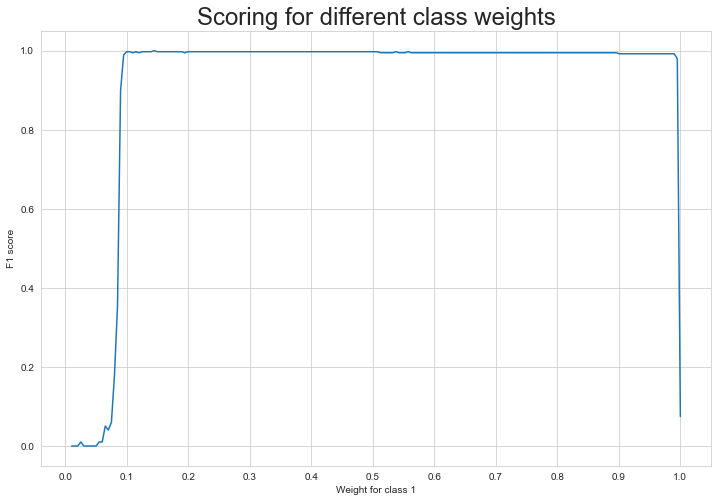

In [66]:
# this cell will take a while.
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Plotting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)


In [67]:
# the optimal class weights:
gridsearch.best_params_

{'class_weight': {0: 0.855678391959799, 1: 0.144321608040201}}

In [68]:
# refit the model:
lr2 = LogisticRegression(solver='newton-cg', 
                        class_weight={0: 0.04974874371859297, 1: 0.950251256281407})

In [69]:
# make a confusion matrix
y_pred_lr_train = gridsearch.best_estimator_.predict(X_train)
confusion_matrix(y_train, y_pred_lr_train)

NameError: name 'confusion_matrix' is not defined

In [ ]:
# predict on the testing data
y_preds = gridsearch.best_estimator_.predict(X_test)
print(len(y_test))
print(len(y_preds))

In [ ]:
# score your model
print(metrics.accuracy_score(y_test, y_preds))
print(metrics.precision_score(y_test, y_preds))
print(metrics.f1_score(y_test, y_preds))

High accuracy - but only because of imbalance classes!

### 4. Evaluate your models on the *training* set

Go deeper than the single metric you used for training. Try showing the confusion matrix for both models - what can you see?

In [64]:
from sklearn.metrics import confusion_matrix

y_pred_lr_train = gridsearch.best_estimator_.predict(X_train)
confusion_matrix(y_train, y_pred_lr_train)

array([[3916,  790],
       [ 120,   70]])

It's clear that the model is just predicting "not bankrupt" for pretty much everything!

# Part 3 - Improvements

Time to improve your models. There are many different things you can do here including:

- choosing more/different features
- trying to tune more hyperparameters (if they exist)
- trying a third model
- tuning other aspects of the prediction process (e.g. changing the cutoff for predicting 1 instead of 0 from the default of 0.5, that is: if your model predicts a company is 50% or more likely to be bankrupt it will predict "bankrupt". Changing this threshold may help improve its performance)

Further reading is available for example in this excellent article [Learning from Imbalanced Classes](https://www.svds.com/learning-imbalanced-classes/)

### 1. Try something to improve your best performing model from above

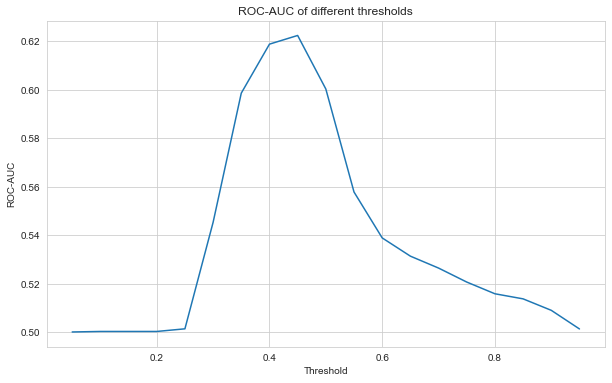

In [65]:
from sklearn.metrics import roc_auc_score

# let's try changing the decision threshold from 0.5
# define a function to try a threshold and return the AUC
def try_threshold(model, X, y, threshold):
    # predict probability of bankruptcy not just 0 or 1
    predicted_proba = model.predict_proba(X)
    
    # only return 1 if probability over chosen threshold
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    
    # evaluate these predictions
    return roc_auc_score(y, predicted)

thresholds_to_try = np.arange(0.05, 1, 0.05)
scores = []

for t in thresholds_to_try:
    scores.append(try_threshold(gridsearch.best_estimator_, X_train, y_train, t))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds_to_try, scores)

ax.set(title="ROC-AUC of different thresholds",
       xlabel="Threshold",
       ylabel="ROC-AUC")

plt.show()

Because the model is never "confident" in non-bankrupt predictions, changing the threshold seems to improve our score.

Try our predictions with a much lower threshold:

In [78]:
proba = gridsearch.best_estimator_.predict_proba(X_test)
y_preds = (proba[:,1] >= 0.5).astype('int')

print(metrics.accuracy_score(y_test, y_preds))
print(metrics.precision_score(y_test, y_preds))
print(metrics.f1_score(y_test, y_preds))

0.8203906622201048
0.08888888888888889
0.14512471655328799


That looks a little healthier.

## Try a different type of model

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
# these parameters are from gridsearch
rf_model= RandomForestClassifier(max_depth=3, min_samples_leaf=25, n_estimators=91)

In [87]:
# fit
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=25, n_estimators=91)

In [88]:
# predict
y_preds=rf_model.predict(X_test)

In [89]:
# score your model
print(metrics.accuracy_score(y_test, y_preds))
print(metrics.precision_score(y_test, y_preds))
print(metrics.f1_score(y_test, y_preds))

0.96141019533111
0.0
0.0


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


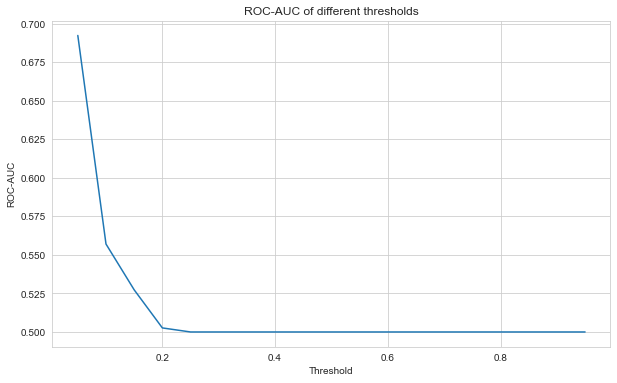

In [90]:
from sklearn.metrics import roc_auc_score

# let's try changing the decision threshold from 0.5
# define a function to try a threshold and return the AUC
def try_threshold(model, X, y, threshold):
    # predict probability of bankruptcy not just 0 or 1
    predicted_proba = model.predict_proba(X)
    
    # only return 1 if probability over chosen threshold
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    
    # evaluate these predictions
    return roc_auc_score(y, predicted)

thresholds_to_try = np.arange(0.05, 1, 0.05)
scores = []

for t in thresholds_to_try:
    scores.append(try_threshold(rf_model, X_train, y_train, t))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds_to_try, scores)

ax.set(title="ROC-AUC of different thresholds",
       xlabel="Threshold",
       ylabel="ROC-AUC")

plt.show()

In [91]:
# Try our predictions with a much lower threshold:
proba = rf_model.predict_proba(X_train)
y_pred_rf_v2 = (proba[:,1] >= 0.05).astype('int')
confusion_matrix(y_train, y_pred_rf_v2)

array([[3570, 1136],
       [  71,  119]])

In [94]:
# and now the testing data
proba = rf_model.predict_proba(X_test)
y_pred_rf_v2 = (proba[:,1] >= 0.05).astype('int')
cm = confusion_matrix(y_test, y_pred_rf_v2)
cm

array([[1511,  507],
       [  36,   45]])

In [96]:
tn = cm[0][0]
tp = cm[1][1]
fn = cm[1][0]
fp = cm[0][1]

In [99]:
# Precision = TP / (TP+FP)
round(tp / (tp + fp), 3)

0.082

In [100]:
# Recall = TP / (TP+FN)
round(tp / (tp + fn), 3)

0.556